# Import the libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import math


# checking the device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Hyperparameters

In [16]:
# Hyperparameters
batch_size = 64
num_epochs = 10
learning_rate = 0.001


# Transformations and Dataset Preparation

In [4]:

# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [5]:
print(transform)

Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)


In [21]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

print(train_dataset)
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [7]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print(train_loader)

# Verify batch size and number of batches

In [8]:
num_train_batches = math.ceil(len(train_dataset) / batch_size)
num_test_batches = math.ceil(len(test_dataset) / batch_size)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Number of training batches: {num_train_batches}")
print(f"Number of test batches: {num_test_batches}")


Number of training samples: 60000
Batch size: 64
Number of training batches: 938
Number of test batches: 157


# Dataset summary function

Summary of Training Dataset:
- Total samples: 60000
- Number of classes: 10
- Samples per class:
  Class 5: 5421 samples
  Class 0: 5923 samples
  Class 4: 5842 samples
  Class 1: 6742 samples
  Class 9: 5949 samples
  Class 2: 5958 samples
  Class 3: 6131 samples
  Class 6: 5918 samples
  Class 7: 6265 samples
  Class 8: 5851 samples


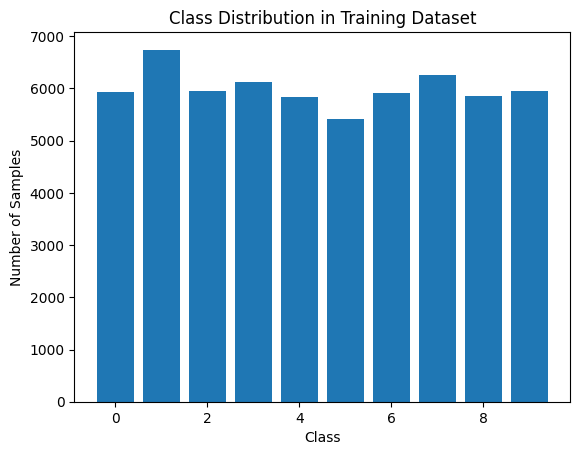

Summary of Test Dataset:
- Total samples: 10000
- Number of classes: 10
- Samples per class:
  Class 7: 1028 samples
  Class 2: 1032 samples
  Class 1: 1135 samples
  Class 0: 980 samples
  Class 4: 982 samples
  Class 9: 1009 samples
  Class 5: 892 samples
  Class 6: 958 samples
  Class 3: 1010 samples
  Class 8: 974 samples


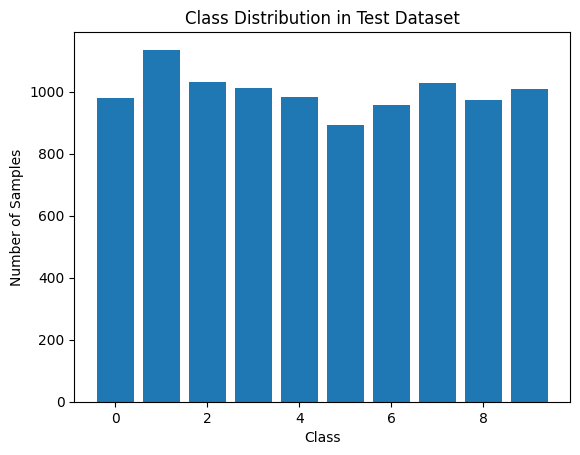

In [9]:

def dataset_summary(dataset, name="Dataset"):
    print(f"Summary of {name}:")
    print(f"- Total samples: {len(dataset)}")

    labels = [label for _, label in dataset]
    label_count = Counter(labels)
    print(f"- Number of classes: {len(label_count)}")
    print(f"- Samples per class:")
    for label, count in label_count.items():
        print(f"  Class {label}: {count} samples")

    # Plot class distribution
    plt.bar(label_count.keys(), label_count.values())
    plt.title(f"Class Distribution in {name}")
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.show()


dataset_summary(train_dataset, "Training Dataset")
dataset_summary(test_dataset, "Test Dataset")


In [10]:
train_labels_count = Counter(train_dataset.targets.numpy())
test_labels_count = Counter(test_dataset.targets.numpy())


In [22]:
print("Number of images in training dataset:", len(train_dataset))
print("Number of images in testing dataset:", len(test_dataset))
print("Class distribution in training dataset:")
for label, count in train_labels_count.items():
    print(f"Class {label}: {count} images")


Number of images in training dataset: 60000
Number of images in testing dataset: 10000
Class distribution in training dataset:
Class 5: 5421 images
Class 0: 5923 images
Class 4: 5842 images
Class 1: 6742 images
Class 9: 5949 images
Class 2: 5958 images
Class 3: 6131 images
Class 6: 5918 images
Class 7: 6265 images
Class 8: 5851 images


# Defining the ANN model

In [38]:
class ANNModel(nn.Module):
    def __init__(self): # Changed _init_ to __init__
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = nn.ReLU()(self.bn1(self.fc1(x)))
        x = nn.ReLU()(self.bn2(self.fc2(x)))
        x = nn.ReLU()(self.bn3(self.fc3(x)))
        x = nn.ReLU()(self.bn4(self.fc4(x)))
        x = self.fc5(x)  # Output layer (logits)
        return x

# Loss and Optimizer

In [39]:
model = ANNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [40]:
print(criterion)
print(optimizer)

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


# Training Loop

In [41]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    return epoch_loss, epoch_accuracy



# Testing Loop

In [42]:
def evaluate(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Accumulate loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(test_loader)
    epoch_accuracy = 100 * correct / total
    return epoch_loss, epoch_accuracy


In [ ]:
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

print("Training complete!")

Epoch 1/10
Train Loss: 0.2341, Train Accuracy: 93.91%
Test Loss: 0.1020, Test Accuracy: 96.84%
Epoch 2/10
Train Loss: 0.0979, Train Accuracy: 97.00%
Test Loss: 0.0815, Test Accuracy: 97.45%
Epoch 3/10
Train Loss: 0.0725, Train Accuracy: 97.73%
Test Loss: 0.0778, Test Accuracy: 97.46%
Epoch 4/10
Train Loss: 0.0547, Train Accuracy: 98.25%
Test Loss: 0.0740, Test Accuracy: 97.71%
Epoch 5/10
Train Loss: 0.0459, Train Accuracy: 98.47%
Test Loss: 0.0638, Test Accuracy: 98.00%
Epoch 6/10
Train Loss: 0.0394, Train Accuracy: 98.74%
Test Loss: 0.0666, Test Accuracy: 98.19%
Epoch 7/10
Train Loss: 0.0347, Train Accuracy: 98.89%
Test Loss: 0.0660, Test Accuracy: 98.23%
Epoch 8/10
Train Loss: 0.0283, Train Accuracy: 99.03%
Test Loss: 0.0658, Test Accuracy: 97.97%


# Saving the Model

In [44]:
torch.save(model.state_dict(), "mnist_ann.pth")
print("Model saved as mnist_ann.pth")


Model saved as mnist_ann.pth


# Per class Accuracy

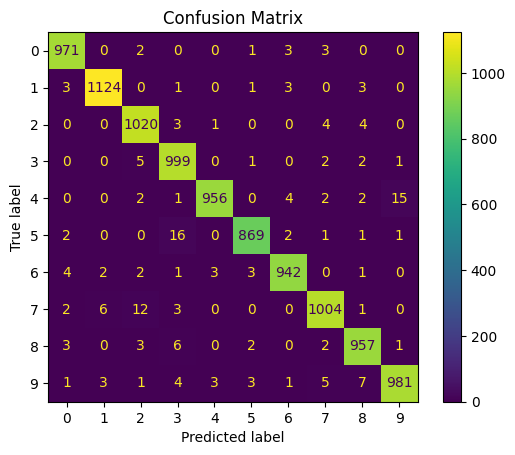

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap="viridis")
plt.title("Confusion Matrix")
plt.show()


# Loss vs. Epochs

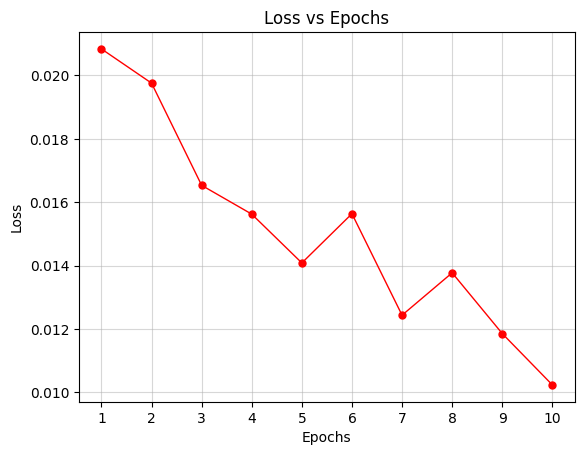

In [46]:

loss_list = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    loss_list.append(epoch_loss / len(train_loader))  # Average loss per epoch

# Plot Loss vs. Epochs
plt.plot(range(1, num_epochs + 1), loss_list, marker='o', linestyle='-', linewidth=1, markersize=5, color='r')
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(alpha=0.5)
plt.xticks(range(1, num_epochs + 1))
plt.show()
